In [3]:
# arguments
import yaml
from omegaconf import OmegaConf
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

In [4]:
EXPERIMENT = "01_NN_MNIST"
MODEL = "trained"
# get the results directory path
results_dir = f"../experiments/{EXPERIMENT}/results/{MODEL}"
print(f"Results directory: {results_dir}")

Results directory: ../experiments/01_NN_MNIST/results/trained


In [5]:
# get model information from config file
args = OmegaConf.create(yaml.load(open(f"../experiments/{EXPERIMENT}/config.yaml"), Loader=yaml.SafeLoader))
plot_title = f"{MODEL.capitalize()} - {args.model_name} - {args.dataset} - Layers: {args.layer_sizes}"
print(f"Plot title: {plot_title}")

Plot title: Trained - NeuralNetwork - MNIST - Layers: [784, 16, 10]


In [6]:
# create lists to store configurations and data
configs = []
all_eigenvalues = []

for lanczos in sorted(os.listdir(results_dir), reverse=True):
    lanczos_dir = os.path.join(results_dir, lanczos)
    if os.path.isdir(lanczos_dir):
        for batch_dir in sorted(os.listdir(lanczos_dir), key=lambda x: int(x.split('_')[1])):
            # skip batch sizes other than 100, 1000, 60000
            if batch_dir not in ["HBS_100", "HBS_1000", "HBS_60000"]:
                continue
            if batch_dir.startswith('HBS_'):
                batch_size = int(batch_dir.split('_')[1])
                batch_path = os.path.join(lanczos_dir, batch_dir)                
                for run_dir in sorted(os.listdir(batch_path)):
                    if run_dir.endswith('_run'):
                        run_path = os.path.join(batch_path, run_dir)
                        run_num = int(run_dir.split('_')[0])
                        # skip runs other than 1, 2, 3
                        if run_num not in [1, 2, 3]:
                            continue
                        for file in sorted(os.listdir(run_path)):
                            if file.startswith('eigenvalues_iter_100'):
                                iter_num = int(file.split('_')[-1].split('.')[0])
                                # skip iterations other than 100
                                if iter_num != 100:
                                    continue
                                # load data
                                eigenvalues = torch.load(os.path.join(run_path, f'eigenvalues_iter_{iter_num}.pt'))
                                weights = torch.load(os.path.join(run_path, f'weights_iter_{iter_num}.pt'))
                                # store configuration and data
                                configs.append({
                                    'lanczos': lanczos,
                                    'batch_size': batch_size,
                                    'run_num': run_num,
                                    'iter_num': iter_num
                                })
                                all_eigenvalues.append(eigenvalues)

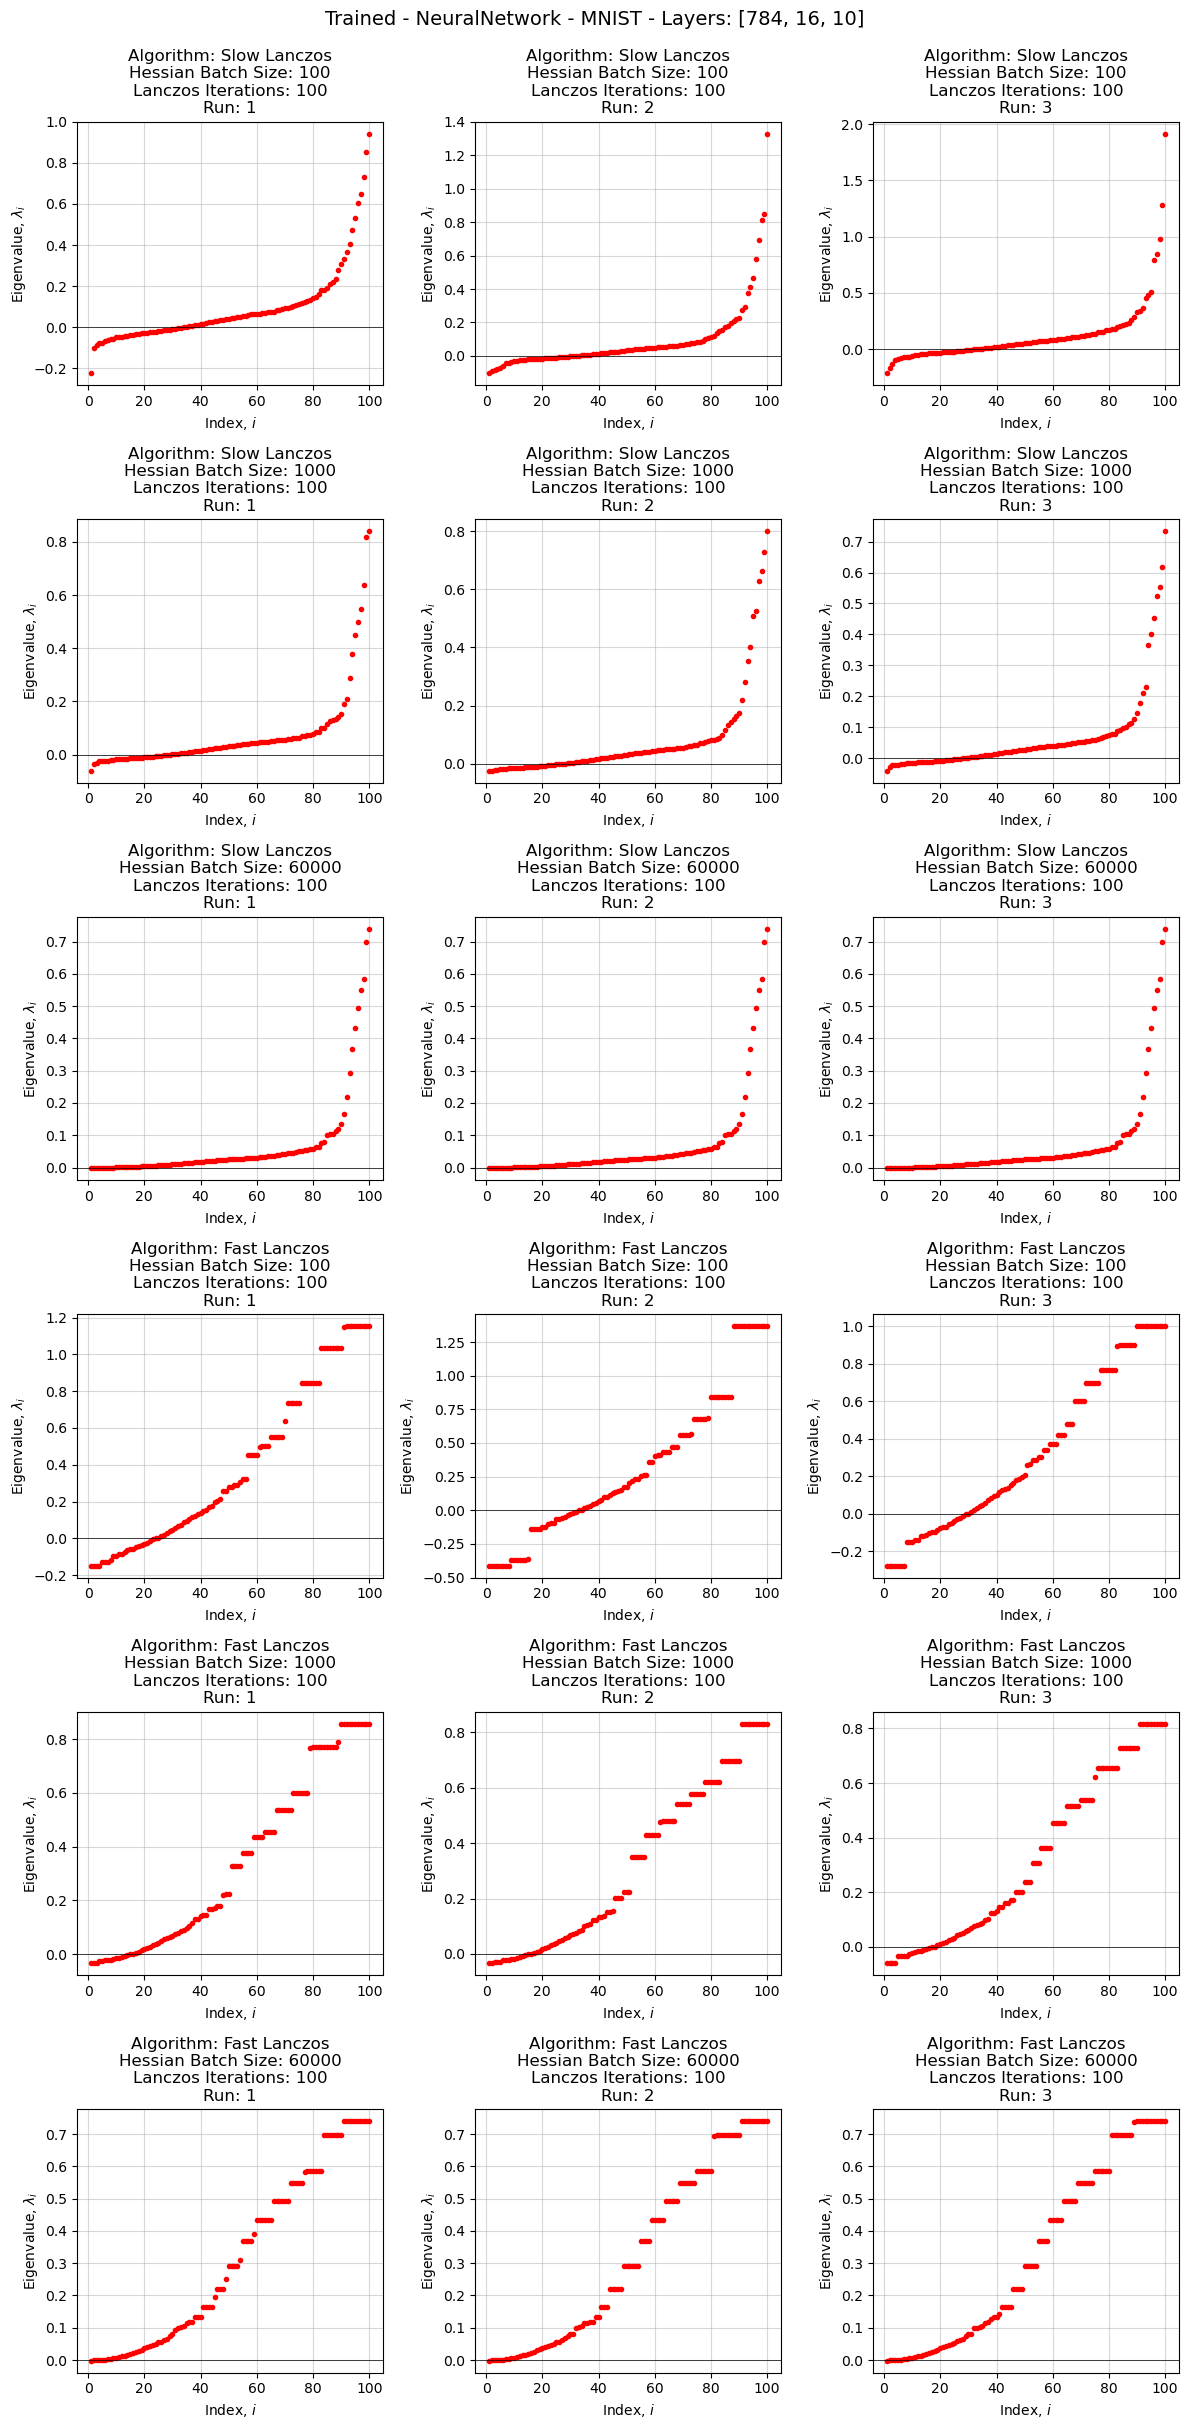

In [7]:
# create subplot grid
n_plots = len(configs)
n_cols = 3  
n_rows = (n_plots + n_cols - 1) // n_cols
# create figure
plt.figure(figsize=(4*n_cols, 4*n_rows))
# create subplots
for idx, (config, eigenvalues) in enumerate(zip(configs, all_eigenvalues)):
    plt.subplot(n_rows, n_cols, idx + 1)
    sorted_eigenvalues = np.sort(eigenvalues)
    x_indices = np.arange(1, len(sorted_eigenvalues) + 1)
    plt.plot(x_indices, sorted_eigenvalues, marker="o", linestyle="", color="red", markersize=3)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)  # Add horizontal line at y=0
    plt.title(f"Algorithm: {config['lanczos'].capitalize()} Lanczos\nHessian Batch Size: {config['batch_size']}\nLanczos Iterations: {config['iter_num']}\nRun: {config['run_num']}")
    plt.grid(True, alpha=0.5)
    plt.xlabel(r"Index, $i$", fontsize=10)
    plt.ylabel(r"Eigenvalue, $\lambda_{i}$", fontsize=10)
plt.tight_layout()
plt.suptitle(plot_title, y=1.01, fontsize=14)
plt.show()

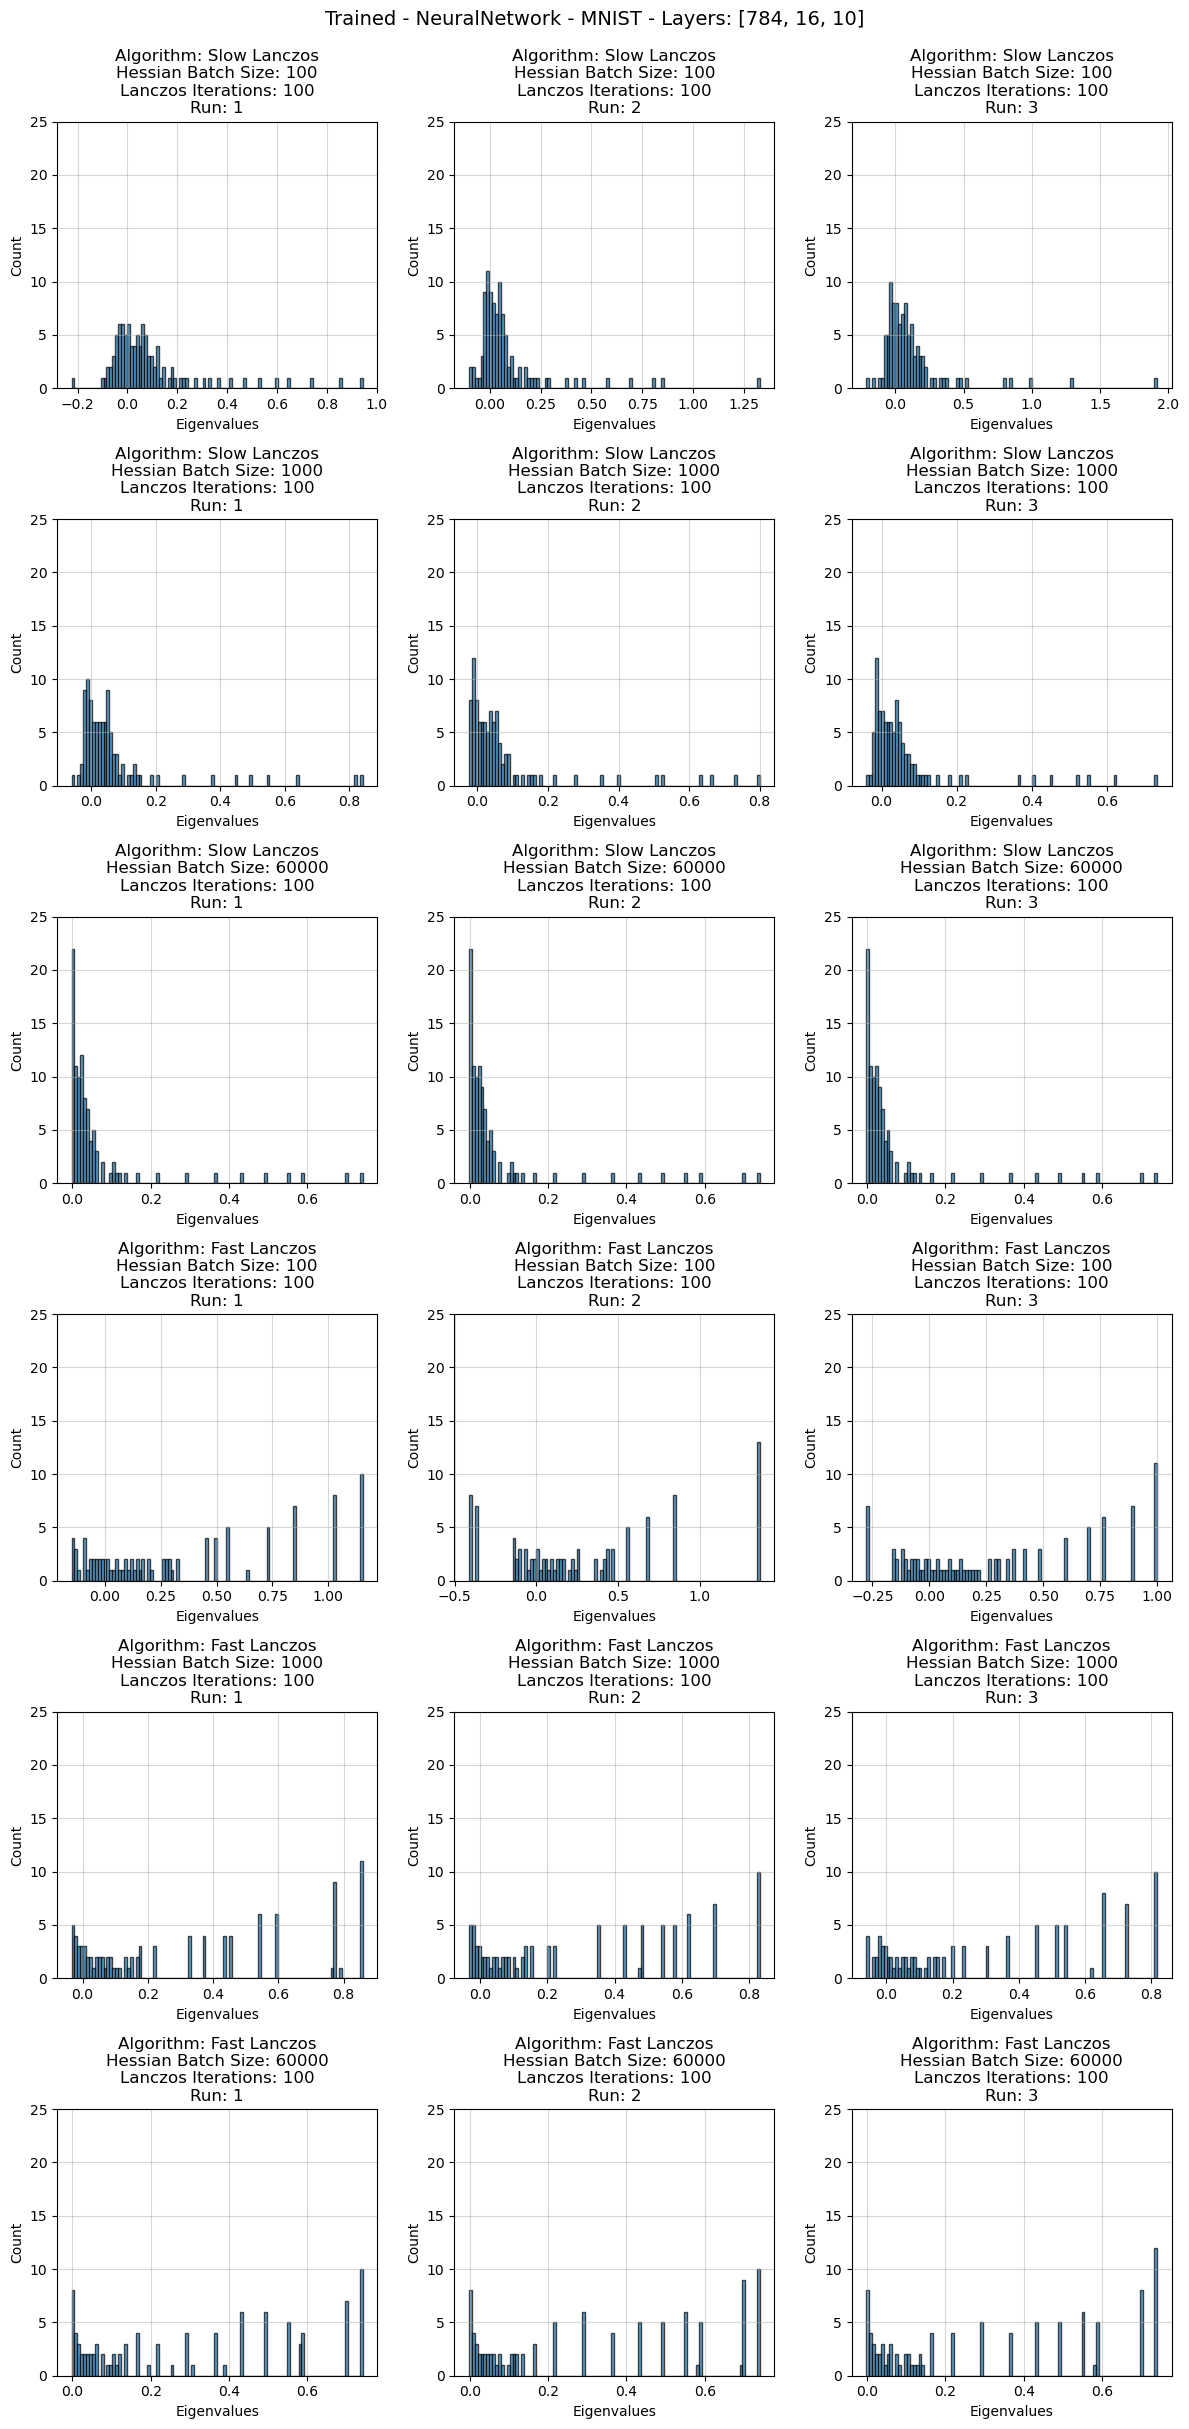

In [8]:
# create subplot grid
n_plots = len(configs)
n_cols = 3  # You can adjust this
n_rows = (n_plots + n_cols - 1) // n_cols
# create figure
plt.figure(figsize=(4*n_cols, 4*n_rows))
# create subplots
for idx, (config, eigenvalues) in enumerate(zip(configs, all_eigenvalues)):
    plt.subplot(n_rows, n_cols, idx + 1)
    plt.hist(eigenvalues, bins=100, alpha=0.7, edgecolor='black')
    plt.title(f"Algorithm: {config['lanczos'].capitalize()} Lanczos\nHessian Batch Size: {config['batch_size']}\nLanczos Iterations: {config['iter_num']}\nRun: {config['run_num']}")
    plt.grid(True, alpha=0.5)
    plt.xlabel("Eigenvalues")
    plt.ylabel("Count")
    plt.ylim(0, 25)

plt.tight_layout()
plt.suptitle(plot_title, y=1.01, fontsize=14)
plt.show()